In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import seaborn
from scipy.stats import skew, entropy, kurtosis, gaussian_kde, pearsonr
from os import listdir

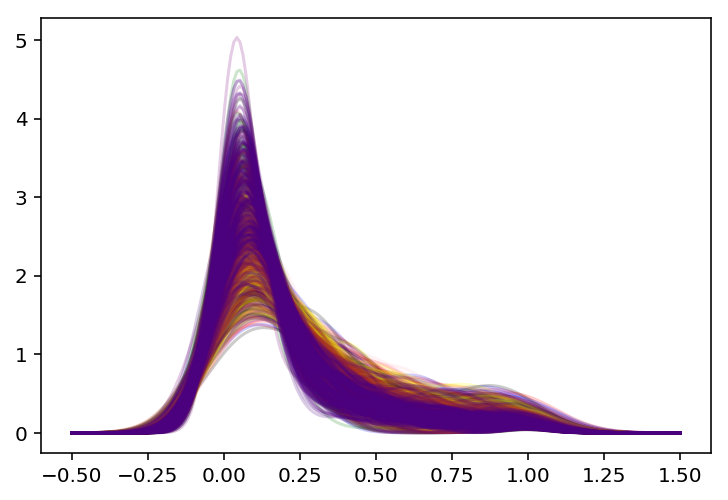

In [3]:
X = linspace( -0.5, 1.5, 200 )

path_noswitch_slow     = { 'path'  : 'simulations/noswitch_slow/',
                           'label' : 'noswitch_slow',
                           'switch': 'none',
                           'g_evol': 'slow',
                           'color' : 'red' }
path_noswitch_balanced = { 'path'  : 'simulations/noswitch_balanced/',
                           'label' : 'noswitch_balanced',
                           'switch': 'none',
                           'g_evol': 'balanced',
                           'color' : 'blue' }
path_noswitch_fast     = { 'path'  : 'simulations/noswitch_fast/',
                           'label' : 'noswitch_fast',
                           'switch': 'none',
                           'g_evol': 'fast',
                           'color' : 'green' }

path_slowswitch_slow     = { 'path'  : 'simulations/slowswitch_slow/',
                             'label' : 'slowswitch_slow',
                             'switch': 'slow',
                             'g_evol': 'slow',
                             'color' : 'pink' }
path_slowswitch_balanced = { 'path'  : 'simulations/slowswitch_balanced/',
                             'label' : 'slowswitch_balanced',
                             'switch': 'slow',
                             'g_evol': 'balanced',
                             'color' : 'black' }
path_slowswitch_fast     = { 'path'  : 'simulations/slowswitch_fast/',
                             'label' : 'slowswitch_fast',
                             'switch': 'slow',
                             'g_evol': 'fast',
                             'color' : 'purple' }

path_fastswitch_slow     = { 'path'  : 'simulations/fastswitch_slow/',
                             'label' : 'fastswitch_slow',
                             'switch': 'fast',
                             'g_evol': 'slow',
                             'color' : 'yellow' }
path_fastswitch_balanced = { 'path'  : 'simulations/fastswitch_balanced/',
                             'label' : 'fastswitch_balanced',
                             'switch': 'fast',
                             'g_evol': 'balanced',
                             'color' : 'brown' }
path_fastswitch_fast     = { 'path'  : 'simulations/fastswitch_fast/',
                             'label' : 'fastswitch_fast',
                             'switch': 'fast',
                             'g_evol': 'fast',
                             'color' : 'indigo' }

allsims = [ path_noswitch_slow,   path_noswitch_balanced,   path_noswitch_fast,
            path_slowswitch_slow, path_slowswitch_balanced, path_slowswitch_fast,
            path_fastswitch_slow, path_fastswitch_balanced, path_fastswitch_fast]

moments = []
data = []

for sim in allsims :
    for run in listdir( sim['path'] ) :
        if run.endswith( '.log' ) : continue
        eg = array( map( float, open( sim['path'] + run + '/eigenvalues.csv').readline().split()[1].split(',') ) )
        density = gaussian_kde( eg/max(eg), bw_method=0.4 ).pdf( X )
        
        moments.append( pandas.read_csv( sim['path'] + run + '/moments.csv' ) )
        d = pandas.read_csv( sim['path'] + run + '/data.csv' )
        sim['run'] = run
        d = pandas.DataFrame([sim]).join(d)
        data.append( d )
        
        plot( X, density, color=sim['color'], alpha=0.2 )
    
moments = pandas.concat( moments, ignore_index=True )
data = pandas.concat( data, ignore_index=True )

In [4]:
q = moments.join(data)
q.head()

,eigengap,skew,occupancy,treedist,p,r,squareness,kurtosis,color,g_evol,...,duplication_rate,prefix,guest_leafs,theta,k,loss_rate,min_guest_leafs,host_leafs,max_guest_leafs,max_host_leafs
0,0.179776,1.123630,1.000000,0.180138,0.197220,0.251218,1.000000,-0.046144,red,slow,...,0.0125,noswitch_slow/run39,8,0.5,2.0,0.0025,4,8,128,128
1,0.341961,0.794785,0.933333,0.150083,0.003365,0.609343,1.142857,-0.737914,red,slow,...,0.0125,noswitch_slow/run50,7,0.5,2.0,0.0025,4,8,128,128
2,0.610641,0.932618,0.769231,0.203625,0.474093,0.256665,1.600000,-0.416426,red,slow,...,0.0125,noswitch_slow/run149,5,0.5,2.0,0.0025,4,8,128,128
3,0.463081,1.111926,1.000000,0.247618,0.000180,0.650255,1.000000,-0.211371,red,slow,...,0.0125,noswitch_slow/run163,8,0.5,2.0,0.0025,4,8,128,128
4,0.101506,1.325231,1.000000,0.243475,0.022413,0.429901,1.000000,0.344731,red,slow,...,0.0125,noswitch_slow/run172,8,0.5,2.0,0.0025,4,8,128,128


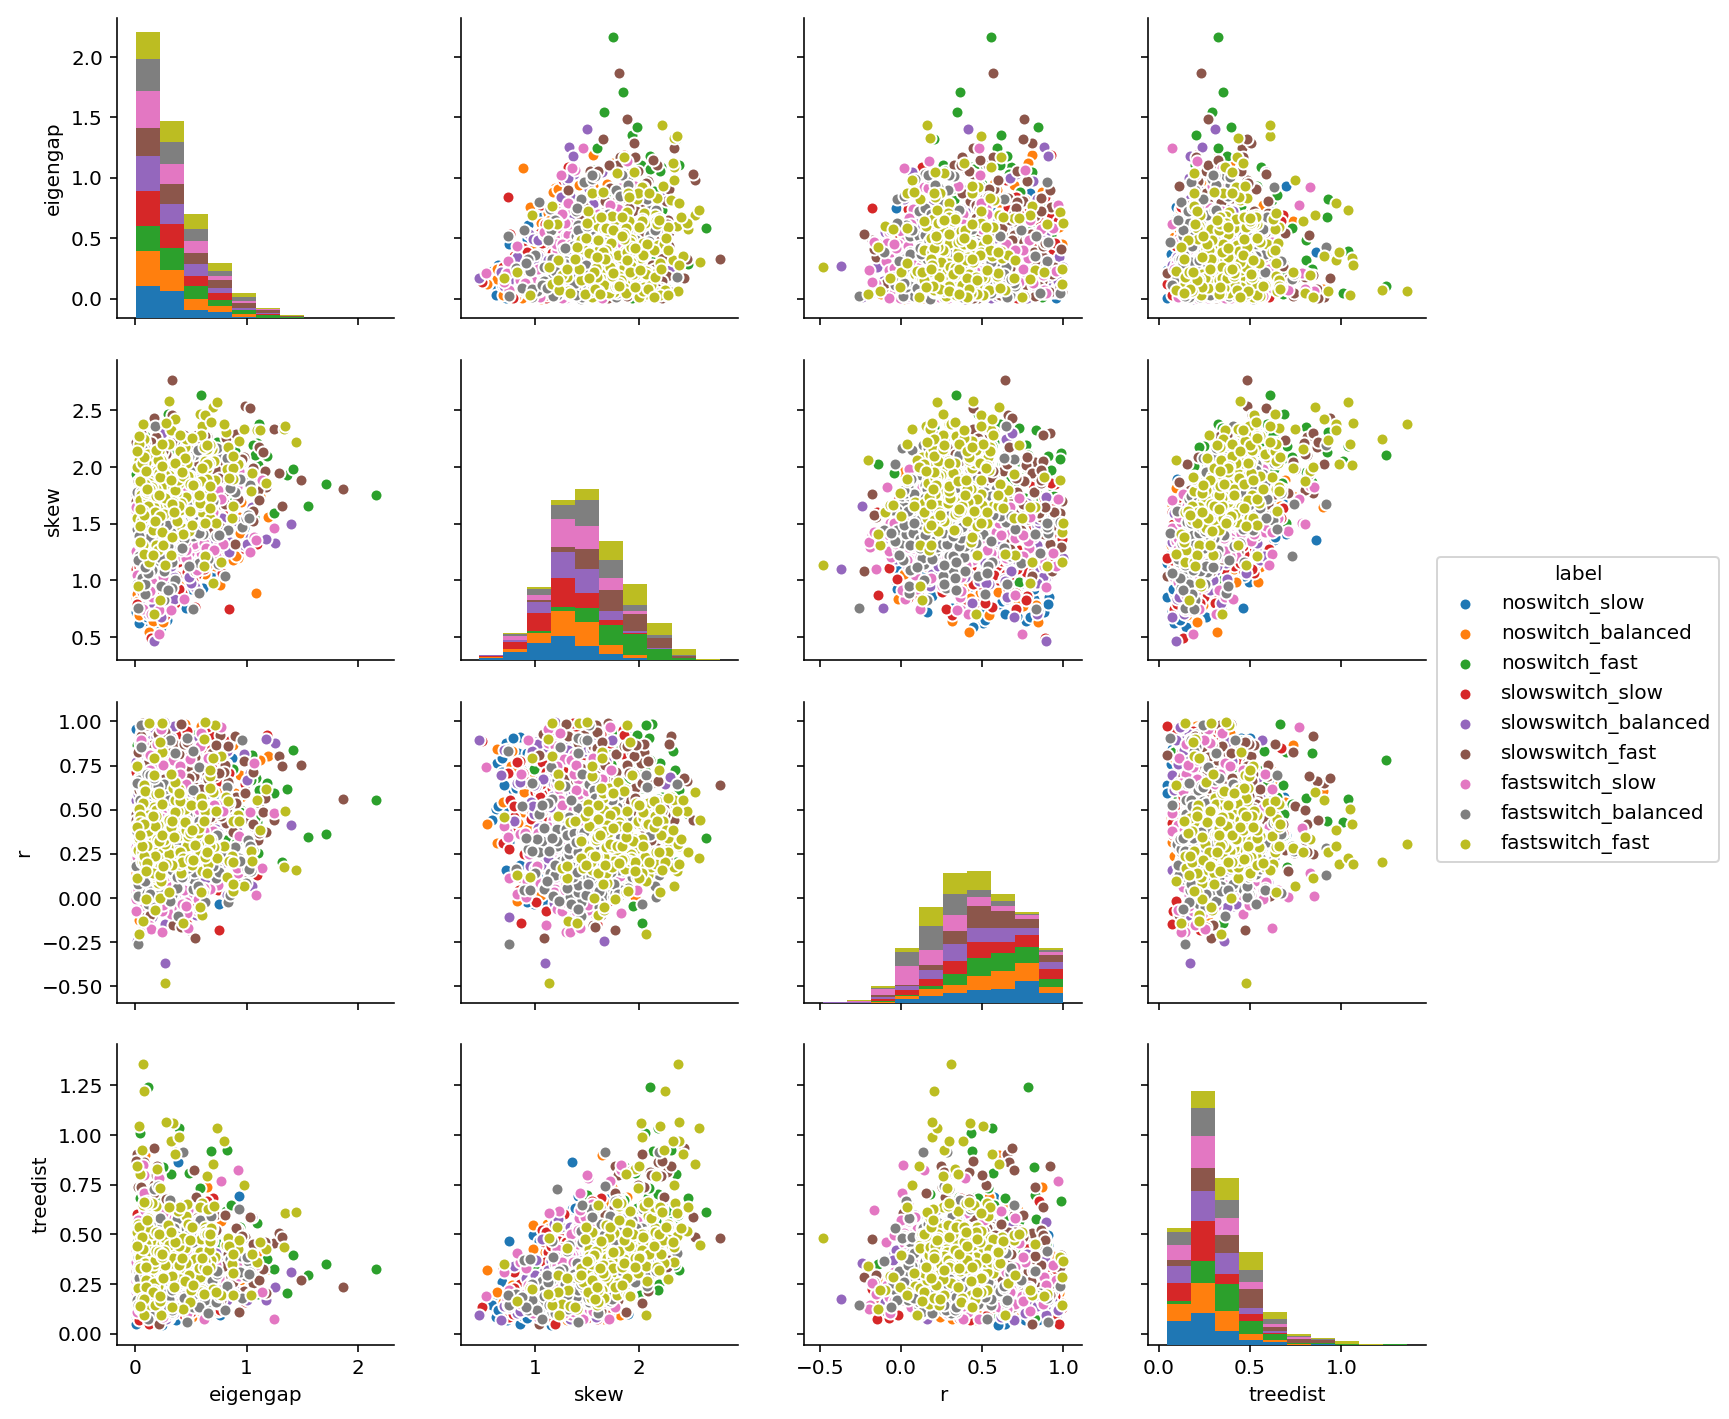

In [5]:
seaborn.pairplot( q.dropna(), vars=['eigengap', 'skew', 'r', 'treedist',], hue='label' )

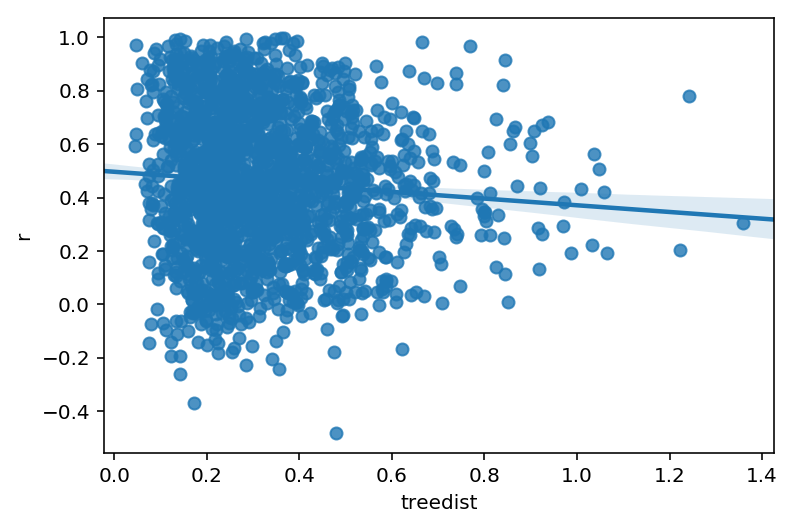

In [6]:
seaborn.regplot( x='treedist', y='r', data=q )

In [7]:
from SuchTree import SuchTree, SuchLinkedTrees
from pyprind import ProgBar

p = ProgBar( len(q), title='building graphs...' )

SLTs = []
igraphs = []
for n,sim in q.iterrows() :
    path = sim['path'] + sim['run'] + '/'
    T1 = SuchTree( path + 'host.relaxed.tree' )
    T2 = SuchTree( path + 'guest.relaxed.tree' )
    LK = pandas.read_csv( path + 'links.csv', index_col=0 )
    SLT = SuchLinkedTrees( T1, T2, LK )
    SLTs.append( SLT )
    igraphs.append( SLT.to_igraph() )
    p.update()

building graphs...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


(array([ 26.,  24.,  33., 147., 136., 134., 116.,  91.,  82.,  87.,  74.,
         64.,  66.,  58.,  41.,  31.,  49.,  34.,  30.,  32.,  33.,  30.,
         22.,  16.,  32.,  20.,  29.,  23.,  18.,  15.,  12.,  14.,  39.,
         13.,   9.,  15.,   9.,   9.,  10.,   9.,   6.,   9.,  11.,   5.,
          3.,   4.,   3.,   4.,   5.,   1.,   1.,   1.,   2.,   2.,   1.,
          0.,   2.,   2.,   2.,   0.,   1.,   1.,   0.,   2.]),
 array([ 4.     ,  5.03125,  6.0625 ,  7.09375,  8.125  ,  9.15625,
        10.1875 , 11.21875, 12.25   , 13.28125, 14.3125 , 15.34375,
        16.375  , 17.40625, 18.4375 , 19.46875, 20.5    , 21.53125,
        22.5625 , 23.59375, 24.625  , 25.65625, 26.6875 , 27.71875,
        28.75   , 29.78125, 30.8125 , 31.84375, 32.875  , 33.90625,
        34.9375 , 35.96875, 37.     , 38.03125, 39.0625 , 40.09375,
        41.125  , 42.15625, 43.1875 , 44.21875, 45.25   , 46.28125,
        47.3125 , 48.34375, 49.375  , 50.40625, 51.4375 , 52.46875,
        53.5    , 54.5

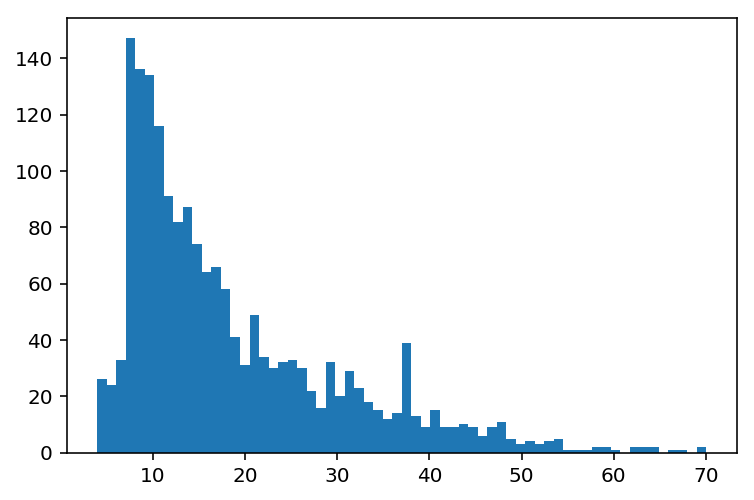

In [8]:
hist( [ SLT.n_links for SLT in SLTs ], 64 )

In [27]:
import graphkernels.kernels as gk

#g = gk.CalculateConnectedGraphletKernel( igraphs )
g = gk.CalculateGraphletKernel( igraphs )

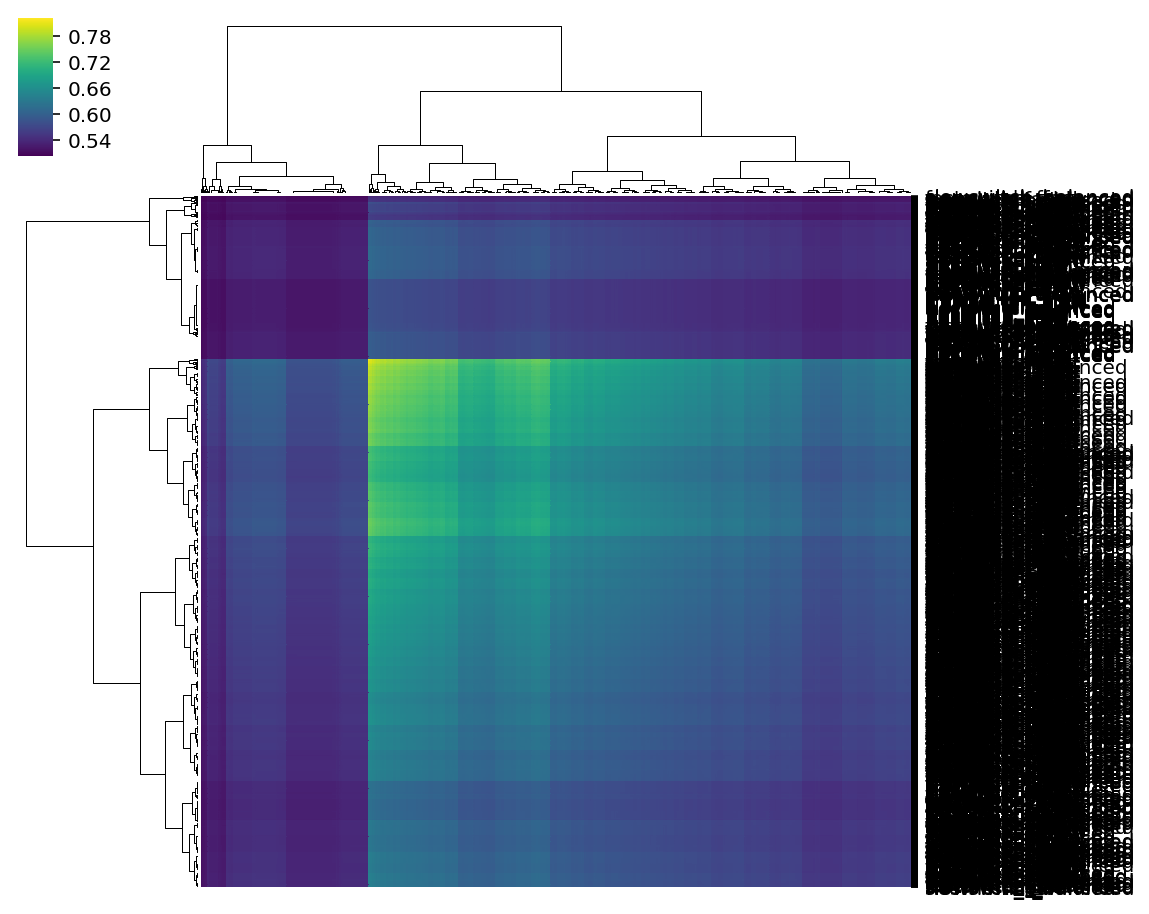

In [28]:
seaborn.clustermap( g, cmap='viridis', method='weighted', metric='braycurtis',
                    figsize=(8,8), xticklabels=False, yticklabels=q.label )

In [30]:
from sklearn.manifold import TSNE

g_embedded = TSNE(n_components=2).fit_transform( g )

In [48]:
q = pandas.DataFrame(g_embedded, columns=['tSNEx','tSNEy']).join(q)

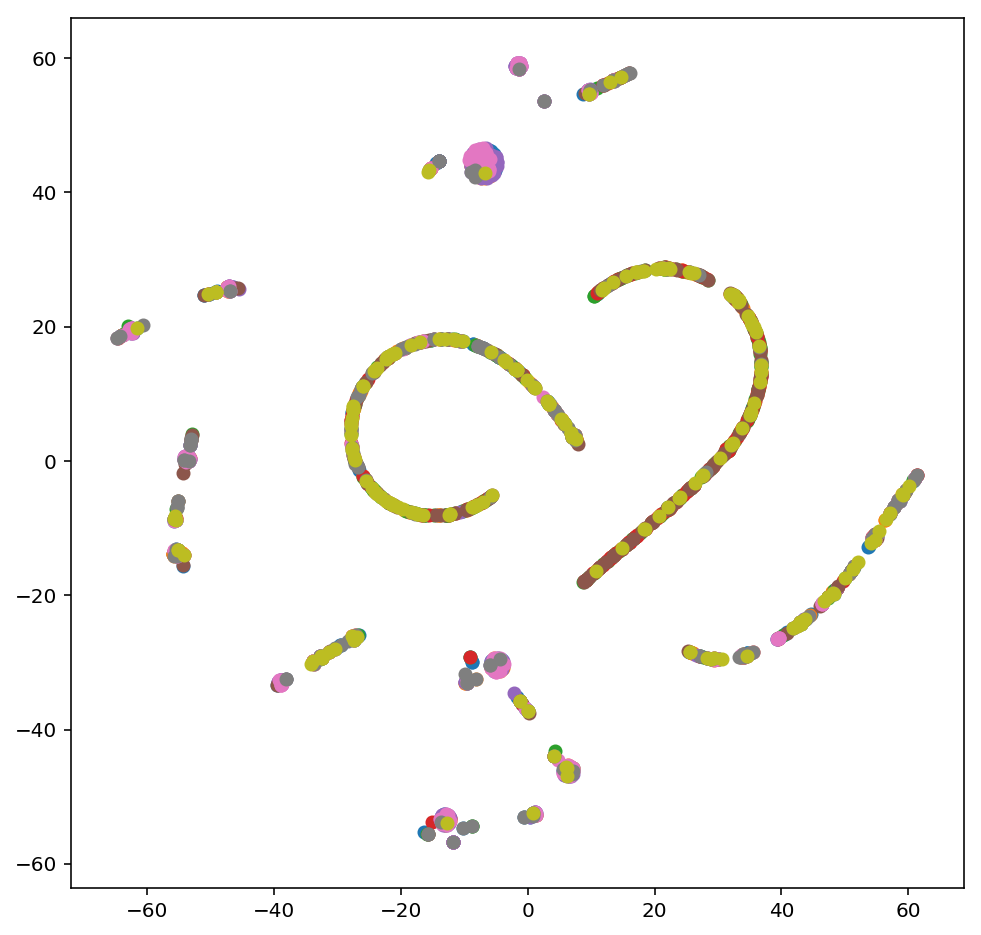

In [65]:
figure( figsize=(8,8) )
for l in set( q.label ) :
    scatter( q[q.label==l]['tSNEx'], q[q.label==l]['tSNEy'] )